In [1]:
import pandas as pd
from src.train import train_loop, test_loop
from src.model import CNNLSTMModel
from src.dataset import InverterTimeSeriesDataset
from src.preprocess import *
from src.visualize import *
import torch

## Hyper-Parameter

In [2]:
performe_visualization = True

In [19]:
# some important parameters
pre_day = 5
window_size = 12*24 # 5 minutes * 12 * 24 = 1 day
stride = 12 # 1 hour stride

feature_cols = [
    #"metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED",  # ambient temperature
    #"metric.STATUS_INTERNAL_TEMP.MEASURED",          # internal temperature
    "metric.AC_VOLTAGE_AB.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_BC.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_CA.MEASURED",                 # AC voltage
    "metric.DC_VOLTAGE.MEASURED"                     # DC voltage
]

exclude_periods = [
    [pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-23')], # data collection issue
    [pd.Timestamp('2023-02-23'), pd.Timestamp('2023-08-26')] # anomalies in the data
]

## Data Preprocessing
### Load Data

In [4]:
inverter_data = load_parquet_data('data/inverter_data')
failure_sessions = load_failure_sessions('data/failure_sessions.csv', min_days=3)

Loaded 15 parquet files → 6126272 rows
Kept 61 sessions longer than 3 days


In [5]:
if performe_visualization:
    # Visualize the raw data
    visualize_hourly_mean_values(inverter_data, failure_sessions, feature_cols, 'visualization', 'raw_data')

Visualizing devices: 100%|██████████| 16/16 [00:44<00:00,  2.78s/it]

Visualization saved at visualization/raw_data/*.html


### Data Cleaning

In [8]:
print("inverter_data shape:", inverter_data.shape)
filtered_data = exclude_periods_from_data(inverter_data, exclude_periods)
print("Excluded data shape:", filtered_data.shape)

inverter_data shape: (6126272, 59)
Excluded data shape: (5172608, 59)


In [9]:
# remove unused columns
filtered_data = filtered_data[['event_local_time', 'device_name'] + feature_cols]

In [ ]:
if performe_visualization:
    # Visualize the filtered data
    visualize_hourly_mean_values(filtered_data, failure_sessions, feature_cols, 'visualization', 'filtered_data')

### Data Labeling

In [10]:
labeled_df = prepare_dataset(filtered_data, failure_sessions, pre_days=pre_day)

Total pre-failure rows: 62652
Total rows: 5026798


### Missing Value Mask

In [11]:
def generate_missing_value_mask(df: pd.DataFrame, features_cols: list[str]) -> pd.DataFrame:
    # Step 1: 缺失 mask
    for col in features_cols:
        df[f"{col}_missing"] = df[col].isna().astype(int)
        
generate_missing_value_mask(labeled_df, feature_cols)

In [20]:
extended_feature_cols = feature_cols+[col+'_missing' for col in feature_cols]

### Missing Value Imputation

In [13]:
imputed_df = missing_value_imputation(labeled_df, feature_cols, time_col='event_local_time', device_col='device_name', short_gap_limit=6, long_fill_value=0.0, add_missing_mask=True)

### Feature Engineering

In [21]:
imputed_df['hour_of_day'] = imputed_df['event_local_time'].dt.hour
extended_feature_cols += ['hour_of_day']

In [16]:
if performe_visualization:
    visualize_hourly_mean_values(imputed_df, failure_sessions, extended_feature_cols+['label'], 
                                title='processed_data')

Visualizing devices: 100%|██████████| 16/16 [01:08<00:00,  4.29s/it]

Visualization saved at visualization/processed_data/*.html


### Split Dataset

In [17]:
train_df, test_df = train_test_split_on_time(imputed_df, 0.3)
val_df, test_df = train_test_split_on_time(test_df, 0.3)

Train set size: 3518759 Train set time range: 2021-12-24 00:00:00 to 2024-08-16 09:30:00
Test set size: 1508039 Test set time range: 2024-08-16 09:30:00 to 2025-07-23 23:35:00
Train set size: 1055628 Train set time range: 2024-08-16 09:30:00 to 2025-04-03 12:30:00
Test set size: 452411 Test set time range: 2025-04-03 12:30:00 to 2025-07-23 23:35:00


### Standardization

In [23]:
from sklearn.preprocessing import StandardScaler
feature_to_standardize = feature_cols + ['hour_of_day']
scaler = StandardScaler()
train_df[feature_to_standardize] = scaler.fit_transform(train_df[feature_to_standardize])
val_df[feature_to_standardize] = scaler.transform(val_df[feature_to_standardize])
test_df[feature_to_standardize] = scaler.transform(test_df[feature_to_standardize])

In [24]:
if performe_visualization:
    visualize_hourly_mean_values(train_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'train_data')
    visualize_hourly_mean_values(val_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'val_data')
    visualize_hourly_mean_values(test_df, failure_sessions, extended_feature_cols+['label'],
                                    'visualization', 'test_data')

Visualizing devices: 100%|██████████| 16/16 [00:52<00:00,  3.27s/it]


Visualization saved at visualization/train_data/*.html


Visualizing devices: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Visualization saved at visualization/val_data/*.html


Visualizing devices: 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]

Visualization saved at visualization/test_data/*.html


### Create Dataset/Data Loader

In [25]:
from torch.utils.data import DataLoader

train_ds = InverterTimeSeriesDataset(train_df, extended_feature_cols, under_sample=True, window_size=window_size, stride=stride)
val_ds   = InverterTimeSeriesDataset(val_df,   extended_feature_cols, window_size=window_size, stride=stride)
test_ds  = InverterTimeSeriesDataset(test_df,  extended_feature_cols, window_size=window_size, stride=stride)

Processing devices: 100%|██████████| 16/16 [00:00<00:00, 32.52it/s]


In [26]:
train_ds.X.shape

torch.Size([6890, 288, 9])

In [27]:
pd.value_counts(val_ds.y.numpy()).sort_index()

0.0    86810
1.0      360
dtype: int64

In [28]:
pd.value_counts(train_ds.y.numpy()), pd.value_counts(val_ds.y.numpy()), pd.value_counts(test_ds.y.numpy())

(0.0    3445
 1.0    3445
 dtype: int64,
 0.0    86810
 1.0      360
 dtype: int64,
 0.0    35751
 1.0     1296
 dtype: int64)

In [29]:
batch_size = 2**8
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=6, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

## Train Model

In [33]:
model = CNNLSTMModel(num_features=len(extended_feature_cols), cnn_out_channels=64, lstm_hidden_size=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

In [50]:
import time

In [51]:
log = train_loop(
    model, train_loader, val_loader, 
    log_interval=10, 
    num_epochs=30, 
    optimizer=optimizer, 
    criterion=criterion,
    save_interval=5,
    save_path='model/0811_1802/',
)

Model moved to cuda
Resuming training from epoch 31
[Epoch 31/30] Step 0/27 - Loss: 0.2057
[Epoch 31/30] Step 10/27 - Loss: 0.1756
[Epoch 31/30] Step 20/27 - Loss: 0.1802
🔁 Epoch 31 finished. Avg Train Loss: 0.1953
✅ Validation Loss: 0.1244 | Accuracy: 79.80%
Best model saved at epoch 31 with loss 0.1244
[Epoch 32/30] Step 0/27 - Loss: 0.1907
[Epoch 32/30] Step 10/27 - Loss: 0.1986
[Epoch 32/30] Step 20/27 - Loss: 0.1895
🔁 Epoch 32 finished. Avg Train Loss: 0.1937
✅ Validation Loss: 0.1251 | Accuracy: 79.83%
[Epoch 33/30] Step 0/27 - Loss: 0.1916
[Epoch 33/30] Step 10/27 - Loss: 0.1831
[Epoch 33/30] Step 20/27 - Loss: 0.2025
🔁 Epoch 33 finished. Avg Train Loss: 0.1952
✅ Validation Loss: 0.1253 | Accuracy: 79.37%
[Epoch 34/30] Step 0/27 - Loss: 0.2023
[Epoch 34/30] Step 10/27 - Loss: 0.1992
[Epoch 34/30] Step 20/27 - Loss: 0.1777
🔁 Epoch 34 finished. Avg Train Loss: 0.1947
✅ Validation Loss: 0.1258 | Accuracy: 79.32%
[Epoch 35/30] Step 0/27 - Loss: 0.1959
[Epoch 35/30] Step 10/27 - Loss

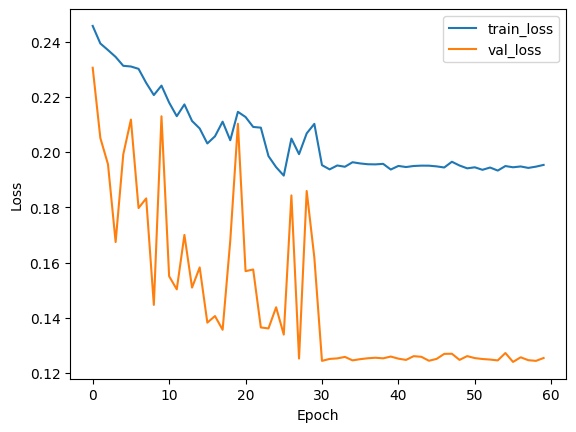

In [52]:
import matplotlib.pyplot as plt
plt.plot(log['train_loss'], label='train_loss')
plt.plot(log['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Model Evaluation

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

def evaluate_model(model, data_loader):
    trues, predictions, outputs = test_loop(model, data_loader, device='cuda', criterion=criterion)
    print(classification_report(trues, predictions , target_names=['Normal', 'Failure']))
    print(confusion_matrix(trues, predictions ))
    roc_auc = roc_auc_score(trues, outputs)
    print(f"ROC AUC: {roc_auc:.4f}")
    curve = roc_curve(trues, outputs)

    plt.figure(figsize=(8, 6))
    plt.plot(curve[0], curve[1], label='ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

In [39]:
model = CNNLSTMModel(num_features=len(extended_feature_cols), cnn_out_channels=64, lstm_hidden_size=128)
model.load_state_dict(torch.load(r'model\0811_1802\best_model.pth', weights_only=True))

<All keys matched successfully>

Performance on Training Set:
🔍 Test Loss: 0.1931 | Accuracy: 66.73%
              precision    recall  f1-score   support

      Normal       0.66      0.69      0.67      3445
     Failure       0.67      0.65      0.66      3445

    accuracy                           0.67      6890
   macro avg       0.67      0.67      0.67      6890
weighted avg       0.67      0.67      0.67      6890

[[2368 1077]
 [1215 2230]]
ROC AUC: 0.7630


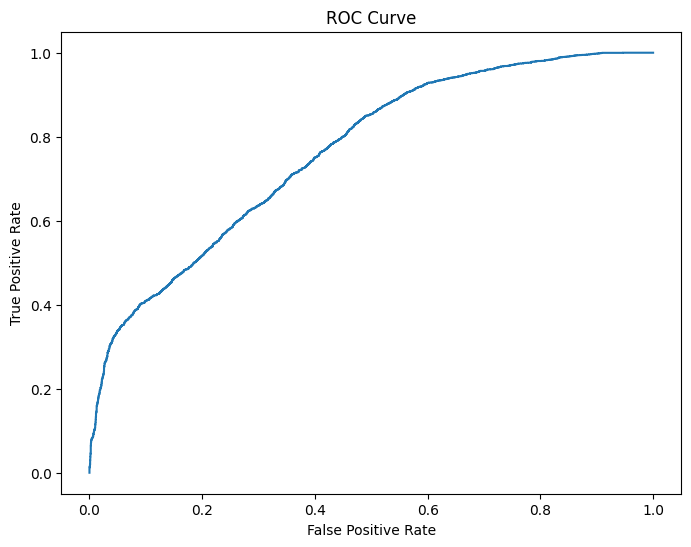

In [53]:
print("Performance on Training Set:")
evaluate_model(model, train_loader)

Performance on Validation Set:
🔍 Test Loss: 0.1254 | Accuracy: 79.50%
              precision    recall  f1-score   support

      Normal       1.00      0.80      0.89     86810
     Failure       0.01      0.51      0.02       360

    accuracy                           0.79     87170
   macro avg       0.50      0.65      0.45     87170
weighted avg       0.99      0.79      0.88     87170

[[69116 17694]
 [  176   184]]
ROC AUC: 0.7948


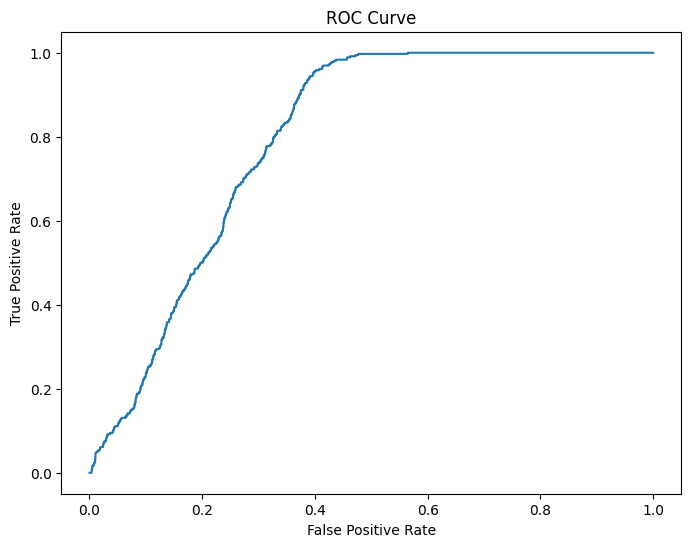

In [54]:
print("Performance on Validation Set:")
evaluate_model(model, val_loader)

Performance on Test Set:
🔍 Test Loss: 0.1471 | Accuracy: 75.70%
              precision    recall  f1-score   support

      Normal       0.97      0.78      0.86     35751
     Failure       0.04      0.26      0.07      1296

    accuracy                           0.76     37047
   macro avg       0.50      0.52      0.46     37047
weighted avg       0.93      0.76      0.83     37047

[[27708  8043]
 [  959   337]]
ROC AUC: 0.5207


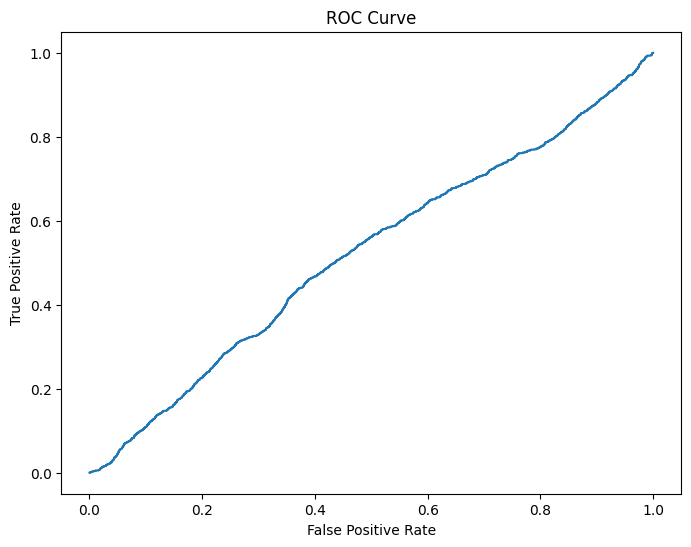

In [55]:
print("Performance on Test Set:")
evaluate_model(model, test_loader)